## Forecasting sunspots

![](https://upload.wikimedia.org/wikipedia/commons/4/47/Solar_Archipelago_-_Flickr_-_NASA_Goddard_Photo_and_Video.jpg)

As a case study we will cosider the problem of forecasting the number of **sunspots** using a dataset collected by the solar physics research department of the Royal Observatory of Belgium ([link](http://sidc.oma.be/)).

In [131]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch

# Set seed for reproducibility and use deterministic algorithms
seed = 42
np.random.seed(seed)
torch.manual_seed(seed)
torch.use_deterministic_algorithms(True)

url = "https://raw.githubusercontent.com/ascarrambad/ml-21-22/main/data/sunspots.csv"

df = pd.read_csv(url, 
                 parse_dates=True, 
                 index_col='Date', 
                 usecols=['Date', 'Monthly Mean Total Sunspot Number'])
df = df.rename(columns={'Monthly Mean Total Sunspot Number':'sunspots'})

In [132]:
df.head()

,sunspots
Date,
1749-01-31,96.7
1749-02-28,104.3
1749-03-31,116.7
1749-04-30,92.8
1749-05-31,141.7


Let's have a look at the data!

Text(0, 0.5, 'n. sunspots')

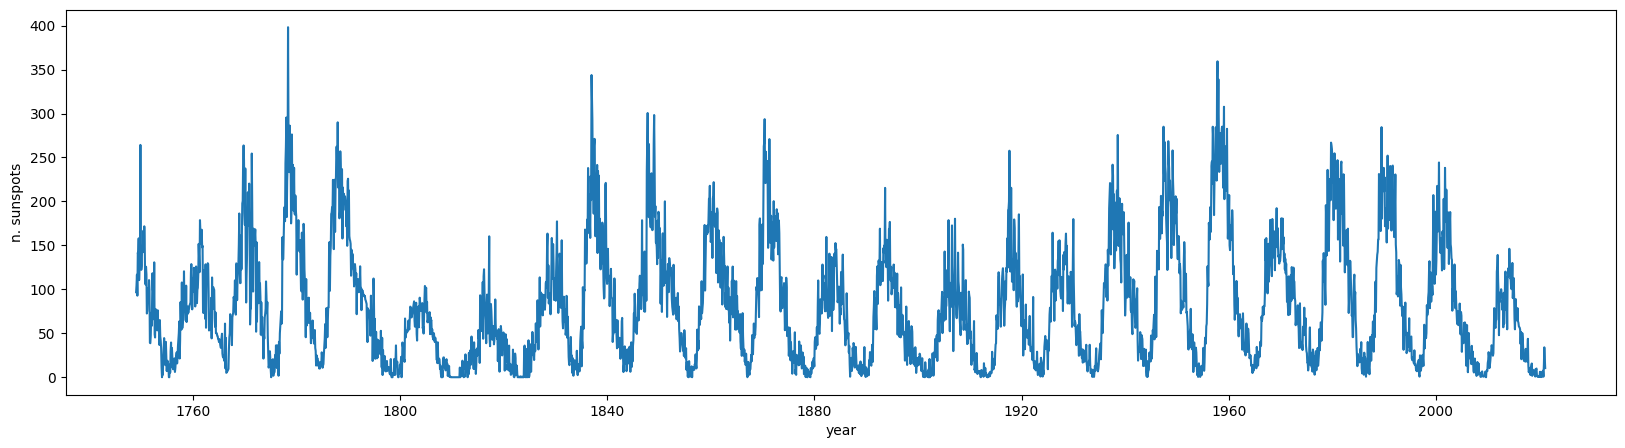

In [133]:
plt.figure(figsize=(20,5))
plt.plot(df.index, df['sunspots'])
plt.xlabel('year')
plt.ylabel('n. sunspots')

First of all let's split our data for model evaluation.

In [134]:
from sklearn.model_selection import train_test_split

# Prepare the data
train_df, test_df = train_test_split(df, test_size=0.2, shuffle=False)

# scale the data
mean = train_df.values.mean()
std = train_df.values.std()

scale = lambda x : (x - mean) / std
inv_scale = lambda x : x * std + mean

train_df = scale(train_df)
test_df = scale(test_df)

### Let's divide data into windows

```
            historical data                   | future observations
--------------------------------------------------------------------
x(1) x(2) ... x(t-p) x(t-p+1) ... x(t-1) x(t) | x(t+1)  x(t+2) ...
                    \________________________/| \____/
                       time window            | value to 
                                              | be predicted
```

In [135]:
# Time windows
def get_time_windows(sequence, window_size):
    time = np.arange(sequence.shape[0])
    xseq = []
    yseq = []
    for t in time[:-window_size]:
        xseq.append(sequence[t:t+window_size])
        yseq.append(sequence[t+window_size])
    xseq = np.array(xseq)
    yseq = np.array(yseq)
    #train-test split
    return xseq, yseq.ravel()


## Recurrent neural networks

Finally let's try out a more advanced architecture: SimpleRNN networks. Documentation [here](https://keras.io/api/layers/recurrent_layers/simple_rnn/)

In [136]:
import torch
import torch.nn as nn
import torch.optim as optim

# Define the simple RNN model
class SimpleRNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(SimpleRNN, self).__init__()
        self.hidden_size = hidden_size
        self.rnn = nn.RNN(input_size, hidden_size, batch_first=True, num_layers=4)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        out, _ = self.rnn(x)
        out = self.fc(out)
        return out

# Define hyperparameters
input_size = 24
hidden_size = 16
output_size = 1
learning_rate = 0.01
num_epochs = 40

# Create the RNN model
model = SimpleRNN(input_size, hidden_size, output_size)

# Define loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Prepare the data
p = 24

x_train, y_train = get_time_windows(sequence=train_df.values.ravel(), window_size=p)
x_train = torch.from_numpy(x_train).float()
y_train = torch.from_numpy(y_train).float().unsqueeze(1)

x_test, y_test = get_time_windows(sequence=test_df.values.ravel(), window_size=p)
x_test = torch.from_numpy(x_test).float()
y_test = torch.from_numpy(y_test).float().unsqueeze(1)

outputs = []
losses = []

# Training loop
for epoch in range(num_epochs):
    # Forward pass
    pred = model(x_train)
    loss = criterion(pred, y_train)

    # Backward and optimize
    optimizer.zero_grad()
    loss.backward()
    losses.append(loss.item())
    optimizer.step()

    outputs.append(pred.detach().numpy())

# Test the trained model
with torch.no_grad():
    predicted_output = model(x_test)

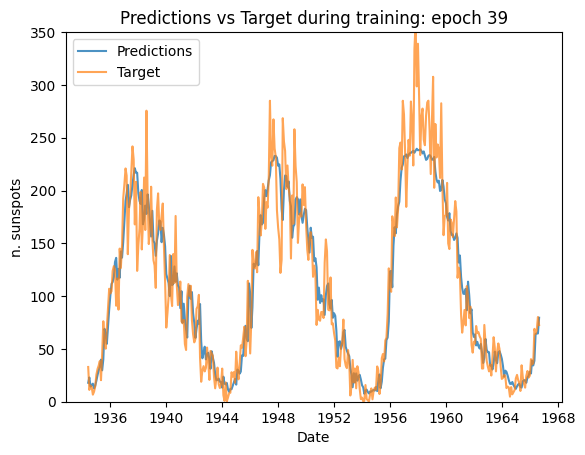

In [137]:
from matplotlib.animation import FuncAnimation
from IPython.display import clear_output

N_TIMES = 2200

# Set up the initial plot (replace this with your own initialization)
fig, ax = plt.subplots()
plt.ylim(0, 350)
# line, = ax.plot(train_df.index[24:], outputs[0], label='Initial Line')

for i in range(1, len(outputs)):
    clear_output(wait=True)
    # Plot the updated data
    plt.plot(train_df.index[24+N_TIMES:], inv_scale(outputs[i][N_TIMES:]), label='Predictions', alpha=0.8)
    plt.plot(train_df.index[24+N_TIMES:], inv_scale(train_df['sunspots'][24+N_TIMES:]), label='Target', alpha=0.7)

    # Customize the plot as needed (title, labels, legend, etc.)
    plt.title('Predictions vs Target during training: epoch {}'.format(i))
    plt.xlabel('Date')
    plt.ylabel('n. sunspots')
    plt.ylim(0, 350)
    plt.legend()
    
    # plt.show()
    plt.pause(0.1)

Now we use the same model to make prediction on the test dataset: new unseen data.

We will make prediction autoregressively

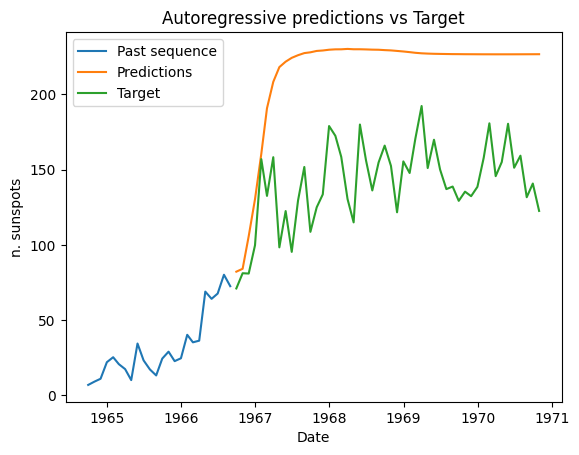

In [142]:
N = 50

# Set the model to evaluation mode
model.eval()

# Provide an initial input sequence
initial_input = train_df['sunspots'][-24:].values

# Convert the initial input to a PyTorch tensor
initial_input = torch.tensor(initial_input, dtype=torch.float32).unsqueeze(0)

# Generate predictions autoregressively
with torch.no_grad():
    predictions = []
    current_input = initial_input

    for _ in range(N):  # N is the number of predictions into the future
        # Forward pass to get the next prediction
        output = model(current_input)

        # Append the prediction to the list
        predictions.append(output.item())

        # Update the current input with the predicted output
        current_input = torch.hstack((current_input[0, 1:], torch.tensor([output.item()]))).unsqueeze(0)

# Plot the predictions
N_PAST = 24
plt.plot(train_df.index[-N_PAST:], inv_scale(train_df['sunspots'][-N_PAST:]), label='Past sequence')
plt.plot(test_df.index[:N], inv_scale(np.array(predictions)), label='Predictions')
plt.plot(test_df.index[:N], inv_scale(test_df['sunspots'][:N]), label='Target')
plt.title('Autoregressive predictions vs Target')
plt.xlabel('Date')
plt.ylabel('n. sunspots')
plt.legend()
plt.show()
